In [68]:
!pip3 install tensorflow_text

## Importing Packages and Libraries

In [69]:
import pandas as pd 
import numpy as np
import nltk
import re 
import os 
import random 
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

In [70]:
tweet_data = pd.read_csv('/content/Tweets.csv')

In [71]:
tweet_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [72]:
tweet_data.shape

(14640, 15)

In [73]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [74]:
print(tweet_data.isnull().sum())

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


## Data Visualization

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


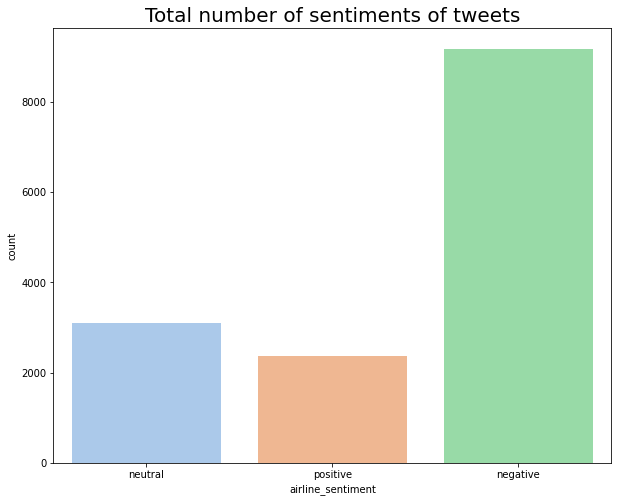

In [75]:
print(tweet_data.airline_sentiment.value_counts())
plt.figure(figsize = (10, 8))
ax = sns.countplot(x = 'airline_sentiment', data = tweet_data, palette = 'pastel')
ax.set_title(label = 'Total number of sentiments of tweets', fontsize = 20)
plt.show()

In [76]:
print(tweet_data.groupby('airline')['airline_sentiment'].count())

airline
American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: airline_sentiment, dtype: int64


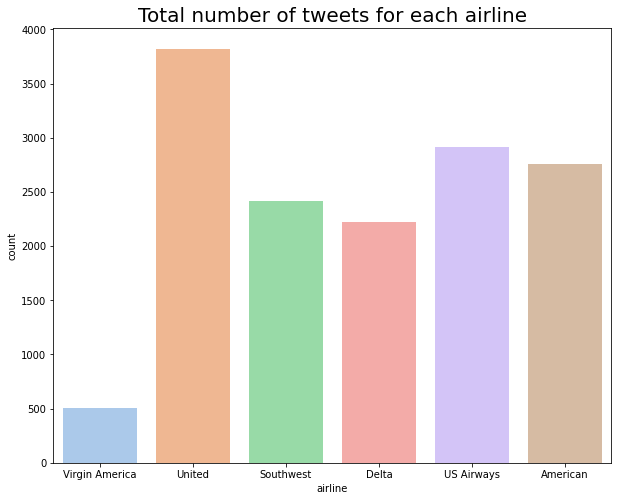

In [77]:
plt.figure(figsize = (10, 8))
ax = sns.countplot(x = 'airline', data = tweet_data, palette = 'pastel')
ax.set_title(label = 'Total number of tweets for each airline', fontsize = 20)
plt.show()

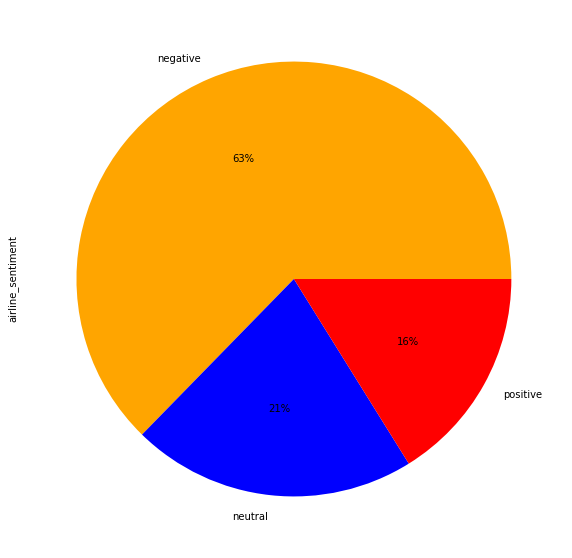

In [78]:
plt.figure(figsize=(20,10))
tweet_data.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["orange", "blue", "red"])

In [79]:
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
for i in airlines :
    print('{} : \n'.format(i),tweet_data.loc[tweet_data.airline == i].airline_sentiment.value_counts())

US Airways : 
 negative    2263
neutral      381
positive     269
Name: airline_sentiment, dtype: int64
United : 
 negative    2633
neutral      697
positive     492
Name: airline_sentiment, dtype: int64
American : 
 negative    1960
neutral      463
positive     336
Name: airline_sentiment, dtype: int64
Southwest : 
 negative    1186
neutral      664
positive     570
Name: airline_sentiment, dtype: int64
Delta : 
 negative    955
neutral     723
positive    544
Name: airline_sentiment, dtype: int64
Virgin America : 
 negative    181
neutral     171
positive    152
Name: airline_sentiment, dtype: int64


Text(0, 0.5, 'No. of Tweets')

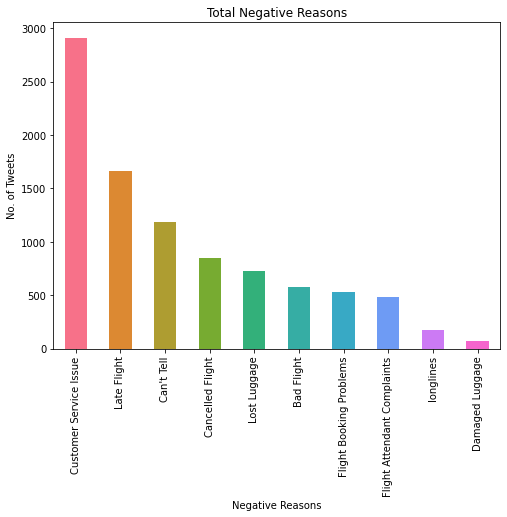

In [80]:
color=sns.color_palette("husl", 10)
pd.Series(tweet_data["negativereason"]).value_counts().plot(kind = "bar",
                        color=color,figsize=(8,6),title = "Total Negative Reasons")
plt.xlabel('Negative Reasons', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

In [81]:
print(tweet_data.negativereason.value_counts())

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


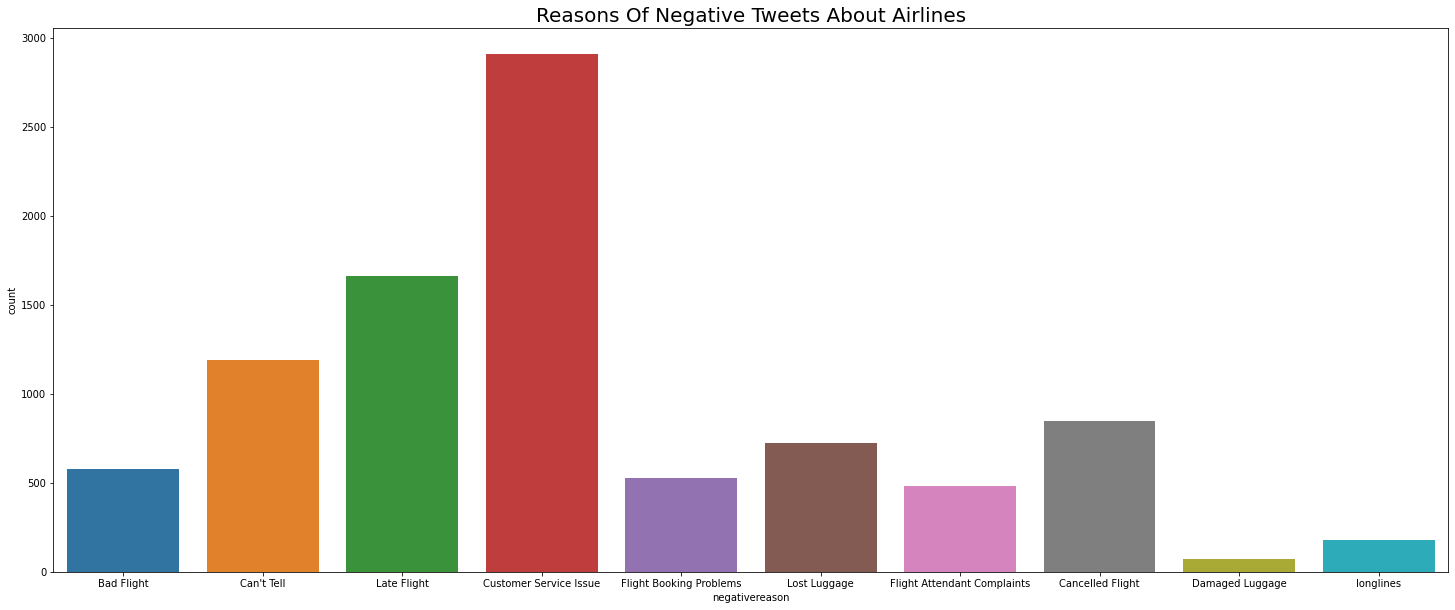

In [82]:
plt.figure(figsize = (25, 10))
sns.countplot(x = 'negativereason', data = tweet_data)
plt.title('Reasons Of Negative Tweets About Airlines', fontsize = 20)
plt.show()

<Figure size 1008x504 with 0 Axes>

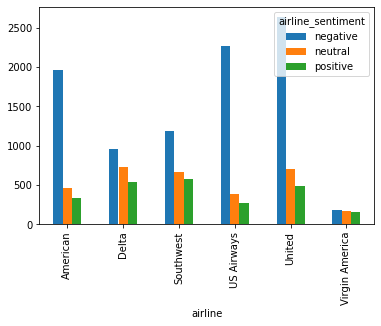

In [83]:
plt.figure(figsize=(14,7))
airline_sentiment = tweet_data.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

In [84]:
positive = tweet_data[tweet_data['airline_sentiment'] == 'positive'].text
neutral  = tweet_data[tweet_data['airline_sentiment'] == 'neutral'].text
negative  = tweet_data[tweet_data['airline_sentiment'] == 'negative'].text

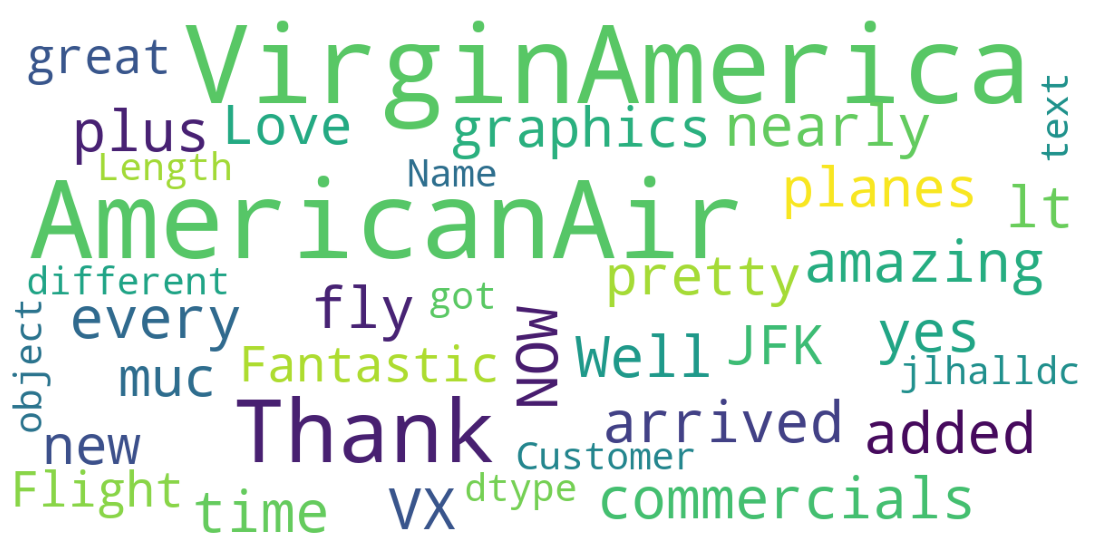

In [85]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(positive)

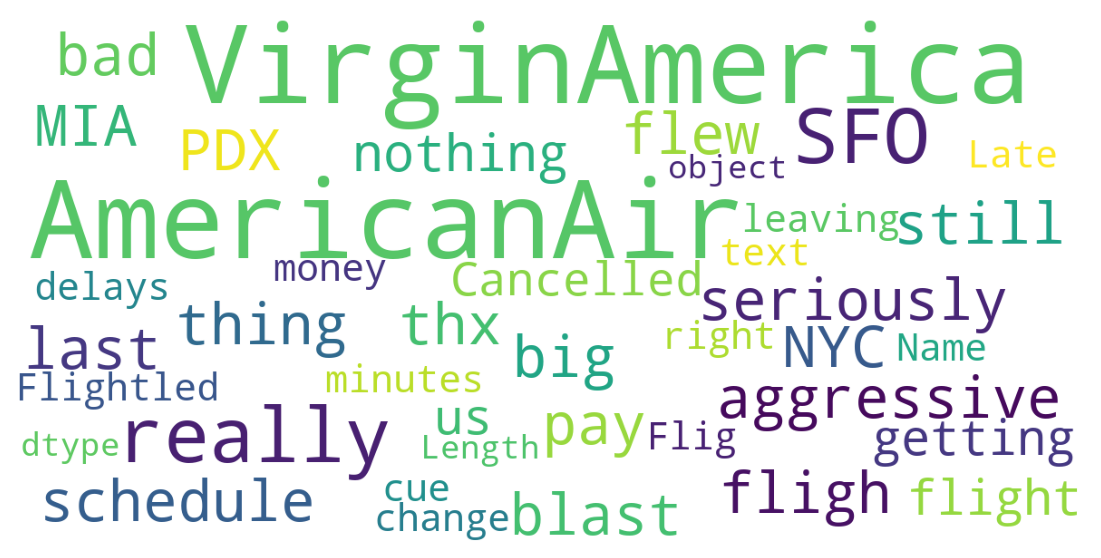

In [86]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(negative)

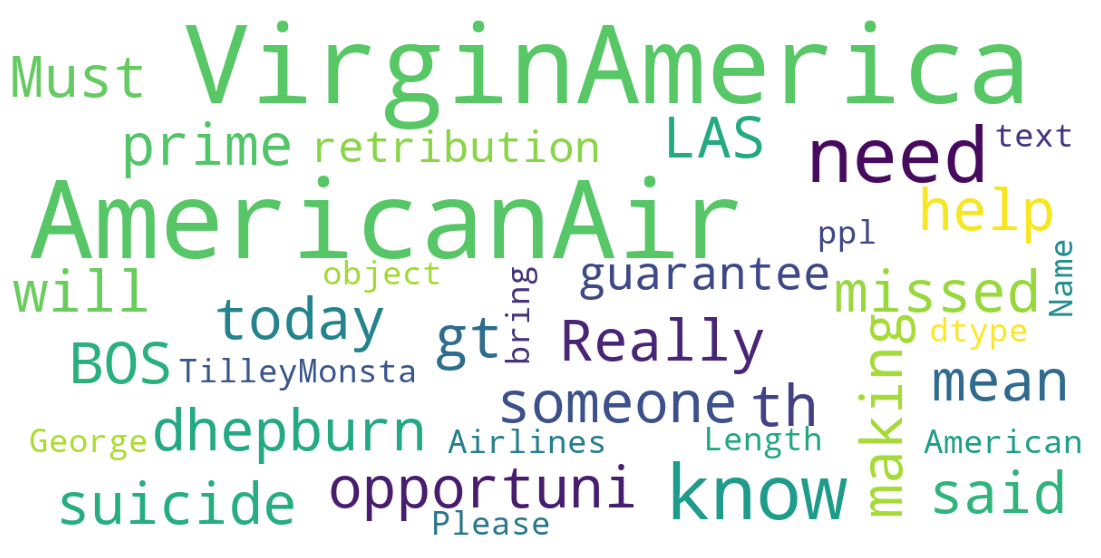

In [87]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(neutral)

## Removing noisy columns from initial dataset

In [88]:
reviews = tweet_data[['text', 'airline_sentiment']].copy()
reviews 

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


## Text Preprocessing

In [89]:
from nltk.corpus import wordnet

In [90]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [91]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
import string
from nltk import pos_tag
from  nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Removing punctuations,stopwords,empty tokens,numbers 

In [92]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [93]:
reviews["review_clean"] = reviews["text"].apply(lambda x: clean_text(x))

In [94]:
reviews

,text,airline_sentiment,review_clean
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica dhepburn say
1,@VirginAmerica plus you've added commercials t...,positive,virginamerica plus added commercial experience...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,virginamerica today must mean need take anothe...
3,@VirginAmerica it's really aggressive to blast...,negative,virginamerica really aggressive blast obnoxiou...
4,@VirginAmerica and it's a really big bad thing...,negative,virginamerica really big bad thing
...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,americanair thank get different flight chicago
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,americanair leave minute late flight warning c...
14637,@AmericanAir Please bring American Airlines to...,neutral,americanair please bring american airline
14638,"@AmericanAir you have my money, you change my ...",negative,americanair money change flight answer phone s...


## Implentation of Bag of Words

In [127]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word", 
                             lowercase=True, 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 150)

wm = vectorizer.fit_transform(reviews["review_clean"])
print(wm.todense())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [128]:
wm.shape

(14640, 150)

In [97]:
vocabulary = vectorizer.vocabulary_
print(vocabulary)

{'virginamerica': 138, 'say': 103, 'experience': 37, 'today': 125, 'need': 83, 'take': 117, 'another': 7, 'trip': 129, 'really': 98, 'amp': 6, 'bad': 11, 'would': 148, 'pay': 91, 'flight': 40, 'seat': 104, 'fly': 43, 'yes': 149, 'time': 124, 'go': 48, 'miss': 80, 'well': 146, 'hour': 55, 'good': 49, 'know': 62, 'much': 82, 'great': 50, 'already': 4, 'think': 122, 'even': 35, 'travel': 128, 'http': 57, 'co': 23, 'thanks': 120, 'still': 114, 'first': 39, 've': 137, 'last': 64, 'week': 145, 'sit': 110, 'due': 33, 'two': 131, 'help': 52, 'please': 95, 'want': 140, 'love': 74, 'make': 76, 'guy': 51, 'give': 47, 'call': 17, 'email': 34, 'response': 101, 'next': 86, 'hr': 56, 'we': 142, 'll': 70, 'can': 18, 'get': 46, 'book': 16, 'problem': 96, 'online': 89, 'leave': 66, 'one': 88, 'answer': 8, 'number': 87, 'phone': 93, 'use': 136, 'service': 107, 'could': 26, 'way': 141, 'best': 14, 'ever': 36, 'airline': 2, 'work': 147, 'ticket': 123, 'new': 85, 'minute': 79, 'website': 144, 'show': 108, '

In [98]:
print(wm.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [99]:
tokens = vectorizer.get_feature_names()
print(tokens)

['aa', 'agent', 'airline', 'airport', 'already', 'americanair', 'amp', 'another', 'answer', 'ask', 'back', 'bad', 'bag', 'baggage', 'best', 'board', 'book', 'call', 'can', 'cancel', 'care', 'change', 'check', 'co', 'come', 'connection', 'could', 'crew', 'customer', 'day', 'delay', 'dfw', 'dm', 'due', 'email', 'even', 'ever', 'experience', 'find', 'first', 'flight', 'flightled', 'flightr', 'fly', 'follow', 'gate', 'get', 'give', 'go', 'good', 'great', 'guy', 'help', 'hold', 'home', 'hour', 'hr', 'http', 'issue', 'jetblue', 'jfk', 'keep', 'know', 'land', 'last', 'late', 'leave', 'let', 'like', 'line', 'll', 'long', 'look', 'lose', 'love', 'luggage', 'make', 'mile', 'min', 'minute', 'miss', 'morning', 'much', 'need', 'never', 'new', 'next', 'number', 'one', 'online', 'passenger', 'pay', 'people', 'phone', 'plane', 'please', 'problem', 're', 'really', 'refund', 'reservation', 'response', 'right', 'say', 'seat', 'see', 'send', 'service', 'show', 'since', 'sit', 'someone', 'southwestair', 's

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [100]:
print(len(tokens))

150


In [101]:
doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                  columns=tokens)
df.head(20)

,aa,agent,airline,airport,already,americanair,amp,another,answer,ask,back,bad,bag,baggage,best,board,book,call,can,cancel,care,change,check,co,come,connection,could,crew,customer,day,delay,dfw,dm,due,email,even,ever,experience,find,first,...,sit,someone,southwestair,staff,still,sure,system,take,tell,thank,thanks,that,think,ticket,time,today,tomorrow,tonight,travel,trip,try,two,unite,united,update,usairways,use,ve,virginamerica,wait,want,way,we,weather,website,week,well,work,would,yes
Doc0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Doc1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Doc2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Doc3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Doc4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Doc5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
Doc6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
Doc7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Doc8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
Doc9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [102]:
stopWords = vectorizer.stop_words
print(stopWords)

None


## Implementation of TF IDF Vectorizer

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=100)
tfidf.fit(reviews['review_clean'])
tfidf_data = tfidf.transform(reviews['review_clean'])

tfidf_data = pd.DataFrame(tfidf_data.toarray(), columns=tfidf.get_feature_names())
tfidf_data.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,agent,airline,airport,americanair,amp,another,back,bad,bag,board,book,call,can,cancel,change,check,could,crew,customer,day,delay,dm,email,even,ever,first,flight,flightled,fly,gate,get,give,go,good,great,guy,help,hold,home,hour,...,one,pay,people,phone,plane,please,problem,really,say,seat,see,send,service,sit,southwestair,still,take,tell,thank,thanks,ticket,time,today,tomorrow,travel,try,unite,united,usairways,use,ve,virginamerica,wait,want,way,weather,well,work,would,yes
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.713405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.700752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.499112,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436143,0.0,0.0,0.0,0.0,0.0,0.453694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.433207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.538143,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.630411,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.559449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.573429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.612761,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.543786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
review = reviews[['review_clean','airline_sentiment']].copy()
review

,review_clean,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plus added commercial experience...,positive
2,virginamerica today must mean need take anothe...,neutral
3,virginamerica really aggressive blast obnoxiou...,negative
4,virginamerica really big bad thing,negative
...,...,...
14635,americanair thank get different flight chicago,positive
14636,americanair leave minute late flight warning c...,negative
14637,americanair please bring american airline,neutral
14638,americanair money change flight answer phone s...,negative


In [105]:
import gensim

review_text = review['review_clean'].apply(gensim.utils.simple_preprocess)
review_text

0                           [virginamerica, dhepburn, say]
1        [virginamerica, plus, added, commercial, exper...
2        [virginamerica, today, must, mean, need, take,...
3        [virginamerica, really, aggressive, blast, obn...
4                 [virginamerica, really, big, bad, thing]
                               ...                        
14635    [americanair, thank, get, different, flight, c...
14636    [americanair, leave, minute, late, flight, war...
14637      [americanair, please, bring, american, airline]
14638    [americanair, money, change, flight, answer, p...
14639    [americanair, ppl, need, know, many, seat, nex...
Name: review_clean, Length: 14640, dtype: object

In [106]:
review_text.loc[2]

['virginamerica', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip']

In [107]:
review['review_clean'].loc[2]

'virginamerica today must mean need take another trip'

## WORD2VEC using gensim library

## Initialize the model

In [108]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4,
)

## Build Vocabulary

In [109]:
model.build_vocab(review_text, progress_per=1000)

## Train the Word2Vec Model

In [110]:
model.train(review_text, total_examples=model.corpus_count, epochs=model.epochs)

(558889, 713735)

In [111]:
model.wv.most_similar("minute")

[('wait', 0.9987741708755493),
 ('min', 0.9972243905067444),
 ('call', 0.9896626472473145),
 ('disconnected', 0.9895898699760437),
 ('hold', 0.9892809391021729),
 ('hr', 0.9889061450958252),
 ('still', 0.9878735542297363),
 ('sit', 0.9870414733886719),
 ('leave', 0.9863494634628296),
 ('try', 0.9842081665992737)]

### If the words are highly correlated the similarity value is above 0.5, otherwise <=0.5

In [112]:
model.wv.similarity(w1="money", w2="many")

0.9997695

In [113]:
model.wv.similarity(w1="added", w2="mean")

0.99220115

In [114]:
model.wv.similarity(w1="get", w2="blast")

0.95852697

## Word Embedding Techniques using Embedding Layer in Keras

In [116]:
from tensorflow.keras.preprocessing.text import one_hot

## vocabulary size

In [117]:
voc_size=10000

## One Hot Representation

In [118]:
onehot_repr=[one_hot(words,voc_size)for words in review['review_clean']] 
print(onehot_repr)

[[9381, 6229, 13], [9381, 9250, 6756, 9266, 7674, 9788], [9381, 3813, 9971, 7283, 4922, 9681, 6732, 1005], [9381, 5765, 1913, 3058, 9104, 248, 1764, 8706, 9538, 9582, 4960], [9381, 5765, 1645, 7522, 152], [9381, 5989, 9889, 2163, 5830, 1487, 8675, 3334, 5765, 7522, 152, 5674, 1836], [9381, 6884, 5941, 2332, 1301, 5674, 8677, 270, 7050, 3826, 7025, 4095], [9381, 5765, 1678, 9253, 844, 3173, 1894, 8164, 701], [9381, 2781, 7927], [9381, 7306, 8973, 8128, 6387, 2411], [9381, 6642, 7629, 7704, 3240, 637, 4571, 7955, 1799], [9381, 5632, 8167, 5865, 2411, 8829, 6718], [9381, 1761, 1690, 2754, 8794, 1005, 9446, 9538, 590, 7025, 1005, 2604], [9381, 5124, 181, 5674, 7886, 2858, 4417, 9681, 8977, 4095, 812, 8794, 3719, 2181, 204], [9381, 7231], [9381, 9901, 6518, 2289, 3813, 4267], [9381, 407, 4368, 6645, 327, 5830, 201, 3713, 2942, 4946, 8862, 1761, 152, 7117, 4145], [9381, 5674, 1142, 9901, 1186, 454, 3931, 1689, 1487, 6381, 5325, 3812, 5428, 3101, 6390, 513], [5594, 5674, 9381, 5926], [9381, 6

## Word Embedding Represntation

In [119]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

In [120]:
sent_length=8
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 9381 6229   13]
 [   0    0 9381 ... 9266 7674 9788]
 [9381 3813 9971 ... 9681 6732 1005]
 ...
 [   0    0    0 ... 3342 6487 2772]
 [1853 4442 5830 ...  960 6135 5649]
 [8148 5830 8100 ... 5632 8148 5830]]


In [121]:
dim=10

In [122]:
model=Sequential()
model.add(Embedding(voc_size,10,input_length=sent_length))
model.compile('adam','mse')

In [123]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 10)             100000    
                                                                 
Total params: 100,000
Trainable params: 100,000
Non-trainable params: 0
_________________________________________________________________


In [124]:
print(model.predict(embedded_docs))

[[[-3.91097441e-02  1.98931582e-02 -3.12487837e-02 ...  3.48417275e-02
    2.75456645e-02 -4.22232151e-02]
  [-3.91097441e-02  1.98931582e-02 -3.12487837e-02 ...  3.48417275e-02
    2.75456645e-02 -4.22232151e-02]
  [-3.91097441e-02  1.98931582e-02 -3.12487837e-02 ...  3.48417275e-02
    2.75456645e-02 -4.22232151e-02]
  ...
  [-4.27828692e-02 -4.23637778e-03 -4.36040647e-02 ... -7.54810870e-04
    7.94917345e-03 -2.38962062e-02]
  [ 3.88020538e-02  1.06660128e-02  3.90328802e-02 ... -1.02783814e-02
   -3.22574005e-02 -1.68917663e-02]
  [-2.82377489e-02  1.20952353e-02  1.04315504e-02 ...  8.84401798e-03
   -4.04195562e-02  2.97479890e-02]]

 [[-3.91097441e-02  1.98931582e-02 -3.12487837e-02 ...  3.48417275e-02
    2.75456645e-02 -4.22232151e-02]
  [-3.91097441e-02  1.98931582e-02 -3.12487837e-02 ...  3.48417275e-02
    2.75456645e-02 -4.22232151e-02]
  [-4.27828692e-02 -4.23637778e-03 -4.36040647e-02 ... -7.54810870e-04
    7.94917345e-03 -2.38962062e-02]
  ...
  [-4.25876305e-03  4.1

In [125]:
embedded_docs[2]

array([9381, 3813, 9971, 7283, 4922, 9681, 6732, 1005], dtype=int32)

In [126]:
print(model.predict(embedded_docs)[0])

[[-0.03910974  0.01989316 -0.03124878  0.00655472 -0.02690762 -0.04992589
   0.01874182  0.03484173  0.02754566 -0.04222322]
 [-0.03910974  0.01989316 -0.03124878  0.00655472 -0.02690762 -0.04992589
   0.01874182  0.03484173  0.02754566 -0.04222322]
 [-0.03910974  0.01989316 -0.03124878  0.00655472 -0.02690762 -0.04992589
   0.01874182  0.03484173  0.02754566 -0.04222322]
 [-0.03910974  0.01989316 -0.03124878  0.00655472 -0.02690762 -0.04992589
   0.01874182  0.03484173  0.02754566 -0.04222322]
 [-0.03910974  0.01989316 -0.03124878  0.00655472 -0.02690762 -0.04992589
   0.01874182  0.03484173  0.02754566 -0.04222322]
 [-0.04278287 -0.00423638 -0.04360406 -0.00402985  0.00366293 -0.04917479
  -0.03385442 -0.00075481  0.00794917 -0.02389621]
 [ 0.03880205  0.01066601  0.03903288  0.03946329 -0.03740234 -0.01476631
  -0.02104731 -0.01027838 -0.0322574  -0.01689177]
 [-0.02823775  0.01209524  0.01043155 -0.00922778 -0.01303637  0.03061639
   0.01418113  0.00884402 -0.04041956  0.02974799]]